## 基于CNN的样式迁移
- Style transfer的奠基性工作
- 下图的这三个网络结构是相同的
- 注意图中的Content loss和Style loss: 内容和样式怎么定义?
- 不是训练权重，而是训练Synthetic image
![softmax-description](./imgs/49-1.png)

In [9]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import d2l 

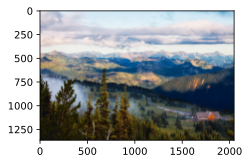

In [10]:
d2l.set_figsize()
content_img = d2l.Image.open('./imgs/rainier.jpg')
d2l.plt.imshow(content_img);

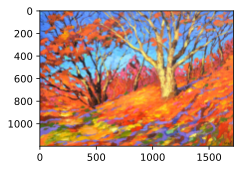

In [12]:
style_img = d2l.Image.open('./imgs/autumn-oak.jpg')
d2l.plt.imshow(style_img);

In [13]:
# 这里是参考了ImageNet标准化的参数
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 预处理: RGB三个通道上分别标准化
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape), # resize 
        torchvision.transforms.ToTensor(), # to tensor
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)]) # normalize
    return transforms(img).unsqueeze(0)

# 后处理: 将输出图像中的像素值还原回标准化之前的值
def postprocess(img):
    img = img[0].to(rgb_std.device) 
    # torch.clamp: 将输入加紧到(0,1)之间
    #      | min, if x_i < min
    #y_i = | x_i, if min <= x_i <= max
    #      | max, if x_i > max

    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [14]:
# 抽取图像特征
# 原论文就用的是vgg19，所以这里用vgg19
# vgg

In [15]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [16]:
# 层数越小越靠近输入，越大越靠近输出
# style_layers:哪些层的输出用于匹配样式
# content_layers: 哪些层的输出用于匹配内容: 越靠近输出匹配内容的效果就越好
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [17]:
# 单*号:将所有参数以元组(tuple)的形式导入：
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])
# 注意这里要加外方括号再加星号
# 28层以后的层都丢掉
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [18]:
# 把style层和contents层的输出分别提取出来
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [26]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device) # content_img这里是指内容图片
    contents_Y, _ = extract_features(content_X, content_layers, style_layers) # 提取content_layers的输出
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device) # style_img这里是指风格图片
    _, styles_Y = extract_features(style_X, content_layers, style_layers) # 提取style_layers的输出
    return style_X, styles_Y

In [19]:
# 定义content_loss
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

# 定义 style_loss:
# 通道间的“统计分布”能匹配上
# 一阶统计信息是“均值”，二阶统计信息是“协方差”
# 类比照片的直方图
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [20]:
# 这是常用降噪算法:TD降噪（总变差降噪）
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [21]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和: 10可以写在最前面的weights里
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [22]:
# 这个weights就是我们要生成的图片
# 这样可以对weight计算梯度进行更新
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [23]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    # gram预先算好，因为gram不变而且计算不便宜
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [24]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

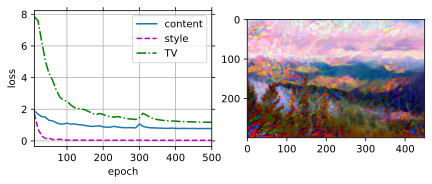

In [27]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)